## Voda Darian-Florian - NLP on YouTube Spam Collection Data Set

## Import libraries

In [247]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Import dataset

In [248]:
df = pd.concat(map(pd.read_csv, [r'C:\Users\daria\PycharmProjects\FH-Karnten-Sem2\Youtube01-Psy.csv', r'C:\Users\daria\PycharmProjects\FH-Karnten-Sem2\Youtube02-KatyPerry.csv', r'C:\Users\daria\PycharmProjects\FH-Karnten-Sem2\Youtube03-LMFAO.csv', r'C:\Users\daria\PycharmProjects\FH-Karnten-Sem2\Youtube04-Eminem.csv', r'C:\Users\daria\PycharmProjects\FH-Karnten-Sem2\Youtube05-Shakira.csv']))
print(f'data shape: {df.shape}')
df.head(5)

data shape: (1956, 5)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


#### Keep in mind that: 1 - SPAM CONTENT, 0 - NOT SPAM CONTENT

## Exploratory Data Analysis (EDA)

In [249]:
df.describe()

,CLASS
count,1956.000000
mean,0.513804
std,0.499937
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 91.7+ KB


In [251]:
df.isnull().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
CLASS           0
dtype: int64

There are 245 NULL values in the dataset, but this feature will be removed
We also have to see the distribution of the two classes

In [252]:
# Describe each feature grouped by class
df.groupby(['CLASS']).describe()

COMMENT_ID                                                           \
           count unique                                          top freq   
CLASS                                                                       
0            951    950  _2viQ_Qnc68fX3dYsfYuM-m4ELMJvxOQBmBOFHqGOk0    2   
1           1005   1003  LneaDw26bFvPh9xBHNw1btQoyP60ay_WWthtvXCx37s    2   

      AUTHOR                        DATE                                     \
       count unique       top freq count unique                         top   
CLASS                                                                         
0        951    922  5000palo    7   951    950  2013-10-05T00:57:25.078000   
1       1005    871     M.E.S    8   760    760         2013-11-07T06:20:48   

           CONTENT                                                 
      freq   count unique                                top freq  
CLASS                                                              
0        2     951    919                              Like﻿    4  
1        1    1005    841  Check out this video on YouTube:﻿   97

Text(0.5, 1.0, 'Distribution of class')

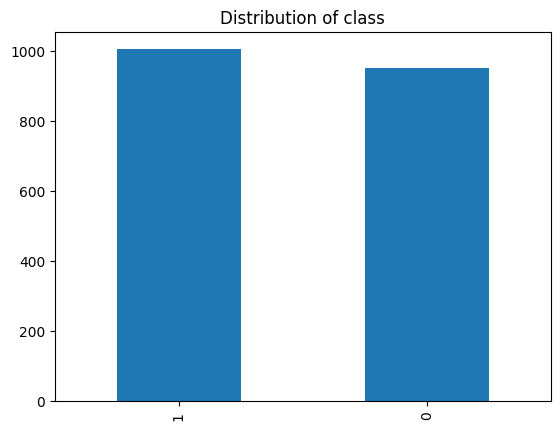

In [253]:
df['CLASS'].value_counts().plot(kind='bar')
plt.title("Distribution of class")

After all this EDA we can conclude that:
- There are 0 values for many features

## Data Preprocessing

In [254]:
df

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
...,...,...,...,...,...
365,_2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0
366,_2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0
367,_2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs,jeffrey jules,2013-07-13T12:09:31.188000,wow,0
368,_2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0


We will get rid of COMMENT_ID, AUTHOR and DATE features since we focus only on text and we will extract features from the words.

In [255]:
df.drop(['COMMENT_ID', 'AUTHOR', 'DATE'], axis=1, inplace=True)
df

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1
...,...,...
365,I love this song because we sing it at Camp al...,0
366,I love this song for two reasons: 1.it is abou...,0
367,wow,0
368,Shakira u are so wiredo,0


## Text Preprocessing

With the package nltk we will:
- Remove all special characters
- Lowercase all the words
- Tokenize
- Remove stopwords
- Lemmatize

[Source](https://www.datacamp.com/tutorial/text-classification-python)

In [256]:
text = list(df['CONTENT'])
lemmatizer = WordNetLemmatizer()
corpus = []

for i in range(len(text)):
    r = re.sub('[^a-zA-Z]', ' ', text[i])
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words('english')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    corpus.append(r)

df['CLEAN_CONTENT'] = corpus

df.head()

,CONTENT,CLASS,CLEAN_CONTENT
0,"Huh, anyway check out this you[tube] channel: ...",1,huh anyway check tube channel kobyoshi
1,Hey guys check out my new channel and our firs...,1,hey guy check new channel first vid u monkey m...
2,just for test I have to say murdev.com,1,test say murdev com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,shaking sexy as channel enjoy
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch v vtarggvgtwq check


### Train/Test Split

In [257]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(df['CLEAN_CONTENT'],
                                                    df['CLASS'], test_size=0.3,random_state=109) # 70% training and 30% test

## Feature Extraction

### I - CountVectorizer

We will use CountVectorizer from sklearn in order to convert clean text into features

In [258]:
# Train Bag of Words model

cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)

X_train_cv.shape

(1369, 3095)

Getting the feature names

In [259]:
cv.get_feature_names_out()

array(['aa', 'aaa', 'aaaaaaa', ..., 'zvrrp', 'zx', 'zxlightsoutxz'],
      dtype=object)

### II - Word2Vec

We will also use Word2Vec approach using gensim model.

Parameters used:
- vector_size - size of the vectors we want
- window - number words before and after the focus word that it’ll consider as context for the word
- min_count - the number of times a word must appear in our corpus in order to create a word vector.

Sources: [S1](https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e) and [S2](https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381) and [S3](https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/)

In [260]:
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)

Convert the preprocessed text data to a vector representation using the Word2Vec model.

In [261]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_vec = np.array([vectorize(sentence) for sentence in X_train])

### III - TF-IDF

In [262]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)

## Train & Evaluate

### Logistic Regression

In [263]:
# Training Logistic Regression model

lr_1 = LogisticRegression()
lr_2 = LogisticRegression()
lr_3 = LogisticRegression()
lr_1.fit(X_train_cv, y_train)
lr_2.fit(X_train_vec, y_train)
lr_3.fit(X_train_vectors_tfidf, y_train)

# transform X_test using CV
X_test_cv = cv.transform(X_test)
X_test_vec = np.array([vectorize(sentence) for sentence in X_test])
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

# generate predictions
y_pred_cv = lr_1.predict(X_test_cv)
y_pred_vec = lr_2.predict(X_test_vec)
y_pred_tfidf = lr_3.predict(X_test_vectors_tfidf)

### Confusion matrix for CountVectorizer

In [264]:
# confusion matrix

confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_cv), index=['spam','not spam'], columns=['spam','not spam'])

confusion_matrix

,spam,not spam
spam,274,6
not spam,24,283


### Confusion matrix for Word2Vec

In [265]:
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_vec), index=['spam','not spam'], columns=['spam','not spam'])

confusion_matrix

,spam,not spam
spam,195,85
not spam,61,246


### Confusion matrix for TF-IDF

In [266]:
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_tfidf), index=['spam','not spam'], columns=['spam','not spam'])

confusion_matrix

,spam,not spam
spam,268,12
not spam,23,284


### Results

In [267]:
print('CountVectorizer Score:')
print('Accuracy:', accuracy_score(y_test, y_pred_cv))
print('Precision:', precision_score(y_test, y_pred_cv))
print('Recall:', recall_score(y_test, y_pred_cv))
print('F1 score:', f1_score(y_test, y_pred_cv))

CountVectorizer Score:
Accuracy: 0.948892674616695
Precision: 0.9792387543252595
Recall: 0.9218241042345277
F1 score: 0.9496644295302012


In [268]:
print('Word2Vec Score:')
print('Accuracy:', accuracy_score(y_test, y_pred_vec))
print('Precision:', precision_score(y_test, y_pred_vec))
print('Recall:', recall_score(y_test, y_pred_vec))
print('F1 score:', f1_score(y_test, y_pred_vec))

Word2Vec Score:
Accuracy: 0.7512776831345827
Precision: 0.743202416918429
Recall: 0.8013029315960912
F1 score: 0.7711598746081505


In [269]:
print('TF-IDF Score:')
print('Accuracy:', accuracy_score(y_test, y_pred_tfidf))
print('Precision:', precision_score(y_test, y_pred_tfidf))
print('Recall:', recall_score(y_test, y_pred_tfidf))
print('F1 score:', f1_score(y_test, y_pred_tfidf))

TF-IDF Score:
Accuracy: 0.9403747870528109
Precision: 0.9594594594594594
Recall: 0.9250814332247557
F1 score: 0.9419568822553896


### Naive Bayes Model - only for CountVectorizer approach due to negative values from Word2Vec

In [270]:
from sklearn.naive_bayes import MultinomialNB

#Create a svm Classifier
clf_1 = MultinomialNB()
clf_2 = MultinomialNB()

#Train the model using the training sets
clf_1.fit(X_train_cv, y_train.values.ravel())
clf_2.fit(X_train_vectors_tfidf, y_train.values.ravel())

# transform X_test using CV
X_test_cv = cv.transform(X_test)
X_test_vec = np.array([vectorize(sentence) for sentence in X_test])
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

# generate predictions
y_pred_cv = clf_1.predict(X_test_cv)
y_pred_tfidf = clf_2.predict(X_test_vectors_tfidf)

### Results

In [271]:
print('CountVectorizer Score:')
print('Accuracy:', accuracy_score(y_test, y_pred_cv))
print('Precision:', precision_score(y_test, y_pred_cv))
print('Recall:', recall_score(y_test, y_pred_cv))
print('F1 score:', f1_score(y_test, y_pred_cv))

CountVectorizer Score:
Accuracy: 0.9148211243611585
Precision: 0.8953846153846153
Recall: 0.9478827361563518
F1 score: 0.9208860759493671


In [272]:
print('TF-IDF Score:')
print('Accuracy:', accuracy_score(y_test, y_pred_tfidf))
print('Precision:', precision_score(y_test, y_pred_tfidf))
print('Recall:', recall_score(y_test, y_pred_tfidf))
print('F1 score:', f1_score(y_test, y_pred_tfidf))

TF-IDF Score:
Accuracy: 0.9063032367972743
Precision: 0.8913043478260869
Recall: 0.9348534201954397
F1 score: 0.9125596184419713


## Overall Results

|              Approach               | Accuracy | Precision | Recall | F1-Score |
|:-----------------------------------:|:--------:|:---------:|:------:|:--------:|
| Logistic Regression CountVectorizer |   0.94   |   0.97    |  0.92  |   0.94   |
|    Logistic Regression Word2Vec     |   0.75   |   0.74    |  0.80  |   0.77   |
|     Logistic Regression TF-IDF      |   0.94   |   0.95    |  0.92  |   0.94   |
|     Naive Bayes CountVectorizer     |   0.91   |   0.89    |  0.94  |   0.92   |
|         Naive Bayes TF-IDF          |   0.90   |   0.89    |  0.93  |   0.91   |

## Conclusions

- For this type of dataset and the size of it, CountVectorizer did better with a Logistic regression than a Naive Bayes approach
- Word2Vec is still a good approach and gives good results with a Logistic Regression
- Word2Vec doesn't get good results as CountVectorizer since the corpus is not very large and also the randomness of the messages is quite high, being there possible content that doesn't make connection between each words
- The results overall are good, but this doesn't prove that Word2Vec is a worse approach than CountVectorizer
- Also, another interesting results is, even though CountVectorizer is used or said to be equivalent with TF-IDF, in practice, in ML it is not true. We can see from this table that the results are slightly changed and CountVectorizer tends to be better in two models for this dataset
- But still, we cannot say that CountVectorizer is better than TF-IDF model from sklearn, but only for this specific case